In [2]:
import atmosphere_bgs
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.ndimage import gaussian_filter

In [3]:
data = atmosphere_bgs.DataLoader("../data/bs_lc1low2001010000", pmin=10, nextra=7)

In [4]:
z = data.y[:,0]
th = data.y[:,1] 
epv = data.epv

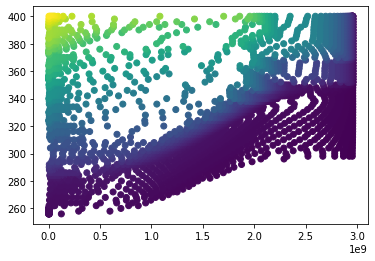

In [5]:
plt.scatter(z,th,c=epv)

In [19]:
z.shape

(2839,)

In [5]:
nextra = 7

In [6]:
# extract input data from the dictionary
latitudes = data.data_dict['LATITUDES ON GAUSSIAN GRID']
pv_lev = data.data_dict['TRACER MIXING RATIO CONTOURS']
th_lev = data.data_dict['ISENTROPIC LEVELS']
lait_to_pv = data.data_dict['FACTOR TO CONVERT FROM LAIT TO ERTEL PV']
bs_circ = data.data_dict['CIRCULATION INTEGRALS IN PV-THETA COORDINATES']
bs_mass = data.data_dict['MASS INTEGRALS IN PV-THETA COORDINATES']

In [7]:
# get physical and simulation parameters
pp = data.pp

earth_radius = pp.a
earth_area = 4*np.pi*pp.a**2
Omega = pp.Omega

In [8]:
# parameter used to place extra mass points near the North Pole in target space
ang_mom_min = Omega*earth_radius**2*(1-data.smax**2) # planetary zonal ang mom at polar cap latitude

# number of pv and theta levels
num_pv_lev = pv_lev.shape[0]; num_th_lev = th_lev.shape[0]

# reshape and rescale circulation and areas vectors
bs_circ = np.reshape(bs_circ,(num_th_lev, num_pv_lev)).T
bs_mass = np.reshape(bs_mass,(num_th_lev,num_pv_lev)).T

d_mass_all = np.diff(bs_mass,axis=0)
if (d_mass_all > 0).any():
    None
    #raise ValueError('Mass data is inconsistent')

In [9]:
# find theta half-levels and layer depth in terms of theta
d_th = -np.diff(th_lev) # this should be positive
d_th = np.ravel(np.append(d_th,d_th[-1])) # dth is the weighting to obtain mass of each isentropic layer
th_lev_h = th_lev + 0.5*d_th
th_lev_h = np.ravel(np.append(th_lev_h,th_lev[-1]-0.5*d_th[-1]))

# get target masses and angular momentum (horizontal coordinates of seeds)
epv_field = np.outer(pv_lev,lait_to_pv) # (num_pv_lev,num_th_lev) numpy array of Ertel PV values

ang_mom = np.zeros([num_pv_lev + nextra -1,num_th_lev])
mass_weight = np.zeros([num_pv_lev + nextra -1,num_th_lev])
pv_mid = np.zeros([num_pv_lev + nextra - 1,num_th_lev])

neg_mass_1 = np.zeros([num_pv_lev + nextra -1,num_th_lev])
neg_mass_2 = np.zeros([num_pv_lev + nextra -1,num_th_lev])

for m in np.arange(num_th_lev):

    d_pv = np.diff(epv_field[:,m])
    d_mass = np.diff(bs_mass[:,m])
    d_circ = np.diff(bs_circ[:,m])

    pv_mid[np.arange(num_pv_lev-1),m] = epv_field[np.arange(num_pv_lev-1),m] + 0.5*d_pv
    c_mid = bs_circ[np.arange(num_pv_lev-1),m] + 0.5*d_circ

    ang_mom[np.arange(num_pv_lev-1),m] = earth_area*c_mid/(2*np.pi)
    mass_weight[np.arange(num_pv_lev-1),m] = -earth_area*d_mass*d_th[m] # d_mass should be negative

    if mass_weight[np.arange(num_pv_lev-1),m].any() < 0:
        None
        #raise ValueError('negative mass at location 0')

    # Find lowest full PV level for which bs_circ=0, if it exists (i.e., at North Pole).
    # Introduce a new mass point at position Z_min to make sure
    # that there is a column of points next to pole.
    # Shift the position of the closest existing point so that the mass is 
    # re-distributed across these two points (total mass is unchanged).
    elz = np.where(bs_circ[:,m] == 0)
    if elz[0].shape[0]>0:
        kp = int(elz[0][0])
    else:
        kp = 0

    if kp > 0:
        zkpm1 = earth_area*bs_circ[kp-1,m]/(2*np.pi)
        if zkpm1 > ang_mom_min:
            dmom = zkpm1/(nextra+1.)
            pvtop = epv_field[kp,m]
            massscal = bs_mass[kp-1,m]/zkpm1

            qscal = (epv_field[kp-1,m]-pvtop)/zkpm1
            zextra = np.zeros([nextra+2])
            mextra = np.zeros([nextra+2])

            # Find angular momentum at new introduced points
            # between Z(kp-1) and Z_min.

            for i in np.arange(nextra+2):
                zextra[i] = zkpm1 - i*dmom

            #m,thlev(m),zextra
            mextra = massscal*zextra

            # Find mass weights, and midpoint Z and Q corresponding to each
            # introduced interval.

            for i in np.arange(nextra+1):
                zmid = zextra[i]-0.5*dmom
                ang_mom[kp-1+i,m] = zmid
                pv_mid[kp-1+i,m] = pvtop + qscal*zmid
                mass_weight[kp-1+i,m] = earth_area*(mextra[i]-mextra[i+1])*d_th[m]
                if np.min(mass_weight) < 0:
                    None
                    #raise ValueError('negative mass location 1')

    # Find repeated points in (M, theta) space.
    # Occurs where same mass and circ assigned to a range of PV values.
    elz = np.argwhere((d_circ == 0) & (c_mid != 0))

    num_elz = elz.shape
    if num_elz[0] > 1:
        # Where this occurs, sum the mass
        sum_mass_weight = np.sum(mass_weight[elz,m])            
        mass_weight[elz,m] = 0
        mass_weight[elz[0],m] = sum_mass_weight

        if np.min(mass_weight) < 0:
            None
            #raise ValueError('negative mass location 2')

In [10]:
mass_check = np.sum(mass_weight)
print('Total mass of point masses: ', mass_check)

Total mass of point masses:  2.333448903645931e+18


In [11]:
# potential temperature
th = np.matlib.repmat(th_lev,num_pv_lev+nextra-1,1) # ((num_pv_lev+nextra-1),num_th_lev) numpy array of potential temperature values

In [12]:
print(pv_mid.shape)
print(th.shape)
print(ang_mom.shape)

(72, 79)
(72, 79)
(72, 79)


In [13]:
# ravel the data
pv_mid = np.ravel(pv_mid)
ang_mom = np.ravel(ang_mom)
th = np.ravel(th)
mass_weight = np.ravel(mass_weight)

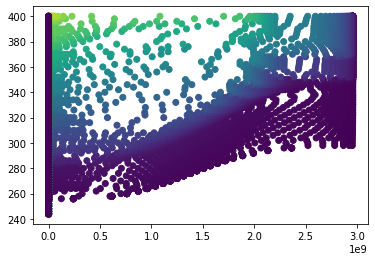

In [14]:
plt.scatter(ang_mom,th,c=pv_mid)

In [15]:
# find indices of seeds with zero angular momentum
idx_mom = ang_mom == 0

# find indices of seeds corresponding to zero target masses
idx_mass = mass_weight == 0

# delete seeds with zero momentum or zero mass
idx = idx_mom | idx_mass
pv_mid = np.delete(pv_mid,idx)
ang_mom = np.delete(ang_mom,idx)
th = np.delete(th,idx)
mass_weight = np.delete(mass_weight,idx)

# create seed and mass arrays
y = np.append(ang_mom[:,None],th[:,None],1)
tm = mass_weight

# eliminate duplicate seeds
y, i = np.unique(y,axis = 0,return_index = True)
tm = tm[i]

# normalise the masses
tmn = tm / np.sum(tm) * (pp.p00 - data.pmin) * (data.smax - data.smin)

# assign seeds and masses to the class instance
data.epv = pv_mid
data.y = y
data.tm = tm
data.tmn = tmn

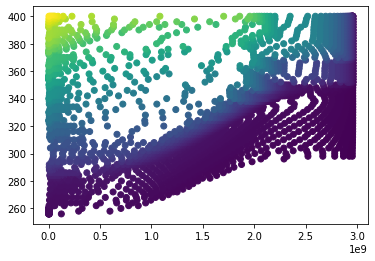

In [16]:
plt.scatter(ang_mom,th,c=epv)

In [21]:
th.shape

(2839,)

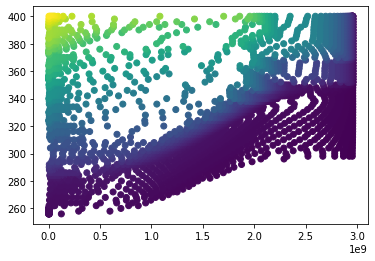

In [19]:
plt.scatter(ang_mom,th,c=epv)